In [5]:
import pandas as pd
import itertools
import numpy as np
import ocel 
import os
import pprint
from prettytable import PrettyTable
from IPython.display import display
import scipy.signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from pyclustering.cluster.optics import optics
from pylab import *
np.random.seed(1)
import pm4py
import json
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
from collections import defaultdict
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix, precision_score, recall_score

In [21]:
def preprocessing(objecttype, targetDataset, ocel): 
#sample_log = app_objects
#for o_type in objecttypes:
    #PARAMs
    
    
    d = {}
    Z = defaultdict(dict)
    remap_cids = []
    all_rels = []
    data = targetDataset
    targetObjects = []
    all_objects = pm4py.ocel_objects_summary(ocel)['ocel:oid']
    for x in all_objects:
        if data['ocel:objects'][x]['ocel:type'] == objecttype :
            targetObjects.append(x)   
    for object in targetObjects:
        Z[object] = {}
    for object in targetObjects:
        filtered_events = []
        #case_ids = []
        #z = defaultdict(dict)
        for event in data.get('ocel:events'):
            #case_ids.append(data['ocel:events'][event]['ocel:vmap']['cID'])
            if object in data['ocel:events'][event]['ocel:omap']:
                filtered_events.append(event)
        for (e1,e2) in list(itertools.combinations(filtered_events, 2)): #list(itertools.combinations(filtered_events, 2)):
            cid = object #data['ocel:events'][e1]['ocel:vmap']['cID'] #object
            if 'event' in data['ocel:events'][e1]['ocel:vmap'].keys():
                a1 = data['ocel:events'][e1]['ocel:vmap']['event']
                a2 = data['ocel:events'][e2]['ocel:vmap']['event']
            else:
                a1 = data['ocel:events'][e1]['ocel:activity']    
                a2 = data['ocel:events'][e2]['ocel:activity']
            t1 = pd.to_datetime(data['ocel:events'][e1]['ocel:timestamp'])
            #a2 = data['ocel:events'][e2]['ocel:vmap']['event']
            t2 = pd.to_datetime(data['ocel:events'][e2]['ocel:timestamp'])
            rel = a1+"->"+a2
            diff = (t2 - t1).total_seconds()
            if rel in d:
                d[rel].append(diff)
            else:
                d[rel] = [diff]
            Z[cid][rel] = diff
            # if rel in Z[cid]:
            #     Z[cid].update({rel: diff})
            # else:
            #     Z[cid][rel] = diff    
            #z[rel] = diff
            #Z[tid] = {rel: diff}
        #Z[object] = z 
    avg = {}
    std = {}
    ext = {}

    for rel, values in d.items():
        avg[rel] = np.mean(values)
        std[rel] = np.std(values)
        ext[rel] = np.max(np.abs(values))
        

    rels = list(d.keys())


    test_time = []

        
    # standardizing
    Zstd = {}
    for cid, trace in Z.items():
        vstd = {}
        for rel, value in trace.items():
            vstd[rel] = (value-avg[rel])
            if std[rel] == 0:
                vstd[rel] = 0
            else:
                vstd[rel] /= std[rel]
        Zstd[cid] = vstd
        
    cids = Z.keys()

    Zvectors = []

    for cid in cids:
        
        temp = Zstd[cid]
        dummy = []
        for rel in rels:
            if rel in temp:
                dummy.append(temp[rel])
            else:
                dummy.append(0.0)
        Zvectors.append(dummy)
        remap_cids.append(cid)



    print("Number of traces: ", len(Zvectors))
    print("Number of relations: ", len(rels))
    
    return Zvectors, remap_cids, rels

    
        

In [10]:
def anomaly_detection(Zvectors, remap_cids, rels, minpoints, eps, prominence):
    minpts = minpoints
    #eps = 10
    #prominence = 1.5
    optics_instance = optics(Zvectors, eps, minpts)

    optics_instance.process()

    clusters = optics_instance.get_clusters()
    noise = optics_instance.get_noise()

    reach = pd.Series(optics_instance.get_ordering())
    left = max(reach)

    reach_smoothed = scipy.signal.savgol_filter(reach, 5, 3)

    if(len(reach)%2 == 0):
        l = len(reach)-1
    else:
        l = len(reach)-2

    yhat = scipy.signal.savgol_filter(reach, l, 3)



    coord1 = [np.array((x,reach_smoothed[x])) for x in range(len(reach_smoothed))]
    coord2 = [np.array((x,yhat[x])) for x in range(len(yhat))]


    diffy = (yhat-reach_smoothed)*yhat


    yhatclip = np.clip(diffy, 0, np.max(diffy))


    peaks, properties = find_peaks(yhatclip, prominence=prominence, width=minpts/2.0)


    cc = {}
    cluster_objects_ids = {}
    entropy_all = {}

    outliers_list = []

    clusters = [val for sublist in clusters for val in sublist]

    for k in range(len(peaks)):
        left = np.ceil(properties["left_ips"][k])
        right = np.floor(properties["right_ips"][k])
        cc[k] = [clusters[l] for l in range(int(left),int(right))]
        
        outliers_list.extend(cc[k])
        cluster = [Zvectors[l] for l in cc[k]]
        
        cluster_objects_ids[k] = [remap_cids[o] for o in cc[k]]
        
        entropies = []
        for i in range(len(rels)):
            rel = rels[i]
            e = np.std([v[i] for v in cluster])
            mean = np.mean([v[i] for v in cluster])
            
            entropies.append((e,rel, mean))
            
        entropy_all[k] = entropies
        
    fig, ax1 = plt.subplots(figsize=(8,2))
    #fig = plt.figure(figsize=(8, 4), dpi=dpi)

    plt.plot(reach_smoothed)
    plt.plot(yhat, color='red')

    if len(peaks) == 1:
        xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
        ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)
    elif len(peaks) > 1:
        for i in range(len(peaks)):
            xs = np.arange(int(properties["left_ips"][i]), int(properties["right_ips"][i]), 1)
            ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"][i]):int(properties["right_ips"][i])], yhat[int(properties["left_ips"][i]):int(properties["right_ips"][i])], color='00', alpha=0.3) 
    #plt.vlines(x=peaks, ymin=reach_smoothed[peaks], ymax = yhat[peaks], color = "C1")
    #plt.hlines(y=reach_smoothed[peaks], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
    plt.title('TOAD Plot' )
    plt.ylabel('Reachability Distance')
    plt.xlabel('Traces')
    plt.show()
    predicted_anomalies = []
    for x in cluster_objects_ids.keys():
        for entry in cluster_objects_ids[x]:
            predicted_anomalies.append(entry)
    return predicted_anomalies

        

In [16]:
def listCaseIds(targetDataset, objecttype):   
    caseIDs = []
    for event in targetDataset['ocel:events']:
        for object in targetDataset['ocel:events'][event]['ocel:omap']:
            if targetDataset['ocel:objects'][object]['ocel:type'] == objecttype:
                caseIDs.append(object)
    caseIDs = list(set(caseIDs)) 
    return caseIDs     

In [2]:
def read_anomaly_list(filepath):    
    # opening the file in read mode 
    my_file = open(filepath, "r") 
    
    # reading the file 
    anomalycids = my_file.read() 
    
    # replacing end splitting the text  
    # when newline ('\n') is seen. 
    anomalycids_list = anomalycids.split("\n")
    for x in anomalycids_list:
        if x == '':
            anomalycids_list.remove(x) 
    #print(anomalycids_list) 
    my_file.close()
    
    return anomalycids_list

In [29]:
def metrics(filepath, txt_filepath, eps, prom):
    data_ocel = pm4py.read_ocel(filepath)
    with open(filepath, 'r') as file:
        targetDataset = json.load(file)
    #ocdfg = pm4py.discover_ocdfg(bpi15)
    #Parameters
    minpoints = [5, 10, 15, 20, 25]#[5, 15, 25, 30, 35, 40, 45]
    objecttype = pm4py.ocel_get_object_types(data_ocel)[0]#'Application' #'Application' 'offer'
    #true labels
    y_true = []
    #list of all case ids
    cids = listCaseIds(targetDataset, objecttype)
    anomalycids_list = read_anomaly_list(txt_filepath)
    for cid in cids:
        if str(cid) in anomalycids_list:
            y_true.append(1)
        else:
            y_true.append(0)
    #counter depicting the number of times each case id has been identified as anomalous
    anomaly_counts = np.zeros(len(cids))
    #F1-Score for each minpoints value
    f1_scores = []
    y_preds = []
    precisionlist = []
    recalllist = []
    pp_results = preprocessing(objecttype, targetDataset, data_ocel)          
    for minPts in minpoints:
        predAnomalies = anomaly_detection(pp_results[0], pp_results[1], pp_results[2], minPts, eps, prom)
        y_pred = []
        for cid in cids:
            if cid in predAnomalies:
                y_pred.append(1)
            else:
                y_pred.append(0)
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
        anomaly_counts += y_pred
        y_preds.append(y_pred)
        print('F1-Score for minpts value ' + str(minPts) + ':' )
        display(f1)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        print('Precision-Score for minpts value ' + str(minPts) + ':' )
        display(precision)
        precisionlist.append(precision)
        recalllist.append(recall)
        print('Recall-Score for minpts value ' + str(minPts) + ':' )
        display(recall)
        #display(y_pred)
            
    #Normalize anomaly counts to get continuous anomaly scores for the auc calculations
    anomaly_scores = anomaly_counts / len(minpoints)
    #AUC ROC score
    rocauc = float(roc_auc_score(y_true, anomaly_scores))
    #AUC PR score
    aucpr = float(average_precision_score(y_true, anomaly_scores))
    #Mean of F1-Scores
    mean_f1 = float(np.mean(f1_scores))
    print('AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45] is: ')
    display(rocauc)
    print('AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45] is: ')
    display(aucpr)
    print('Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45] is: ') 
    display(mean_f1)
    mean_precision = float(np.mean(precisionlist))
    mean_recall = float(np.mean(recalllist))
    results_dict = {'F1': round(mean_f1,2),
                    'AUC ROC': round(rocauc,2),
                    'AUC Precision-Recall': round(aucpr,2),
                    'Mean Precision' : round(mean_precision,2),
                    'Mean Recall' : round(mean_recall,2)
                    }
    results_df = pd.DataFrame([results_dict], index=[0])
    return results_df
    

Number of traces:  5000
Number of relations:  24


C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


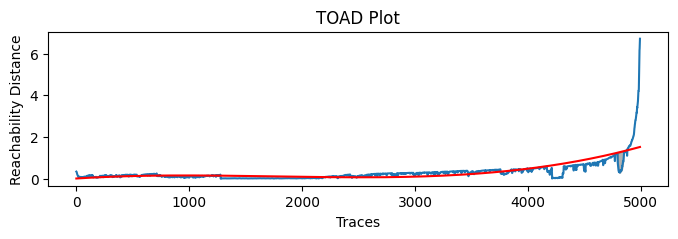

F1-Score for minpts value 5:


np.float64(0.5562913907284768)

Precision-Score for minpts value 5:


np.float64(0.84)

Recall-Score for minpts value 5:


np.float64(0.4158415841584158)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


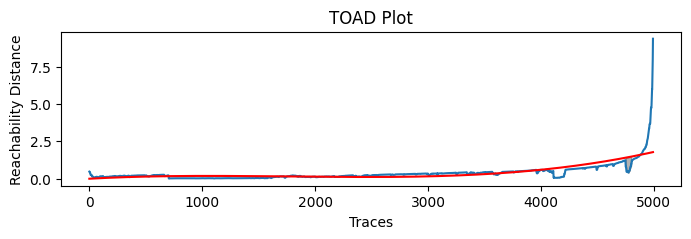

F1-Score for minpts value 10:


np.float64(0.5733333333333334)

Precision-Score for minpts value 10:


np.float64(0.8775510204081632)

Recall-Score for minpts value 10:


np.float64(0.42574257425742573)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


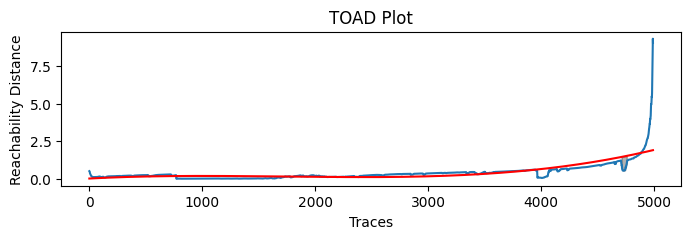

F1-Score for minpts value 15:


np.float64(0.5945945945945946)

Precision-Score for minpts value 15:


np.float64(0.9361702127659575)

Recall-Score for minpts value 15:


np.float64(0.43564356435643564)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


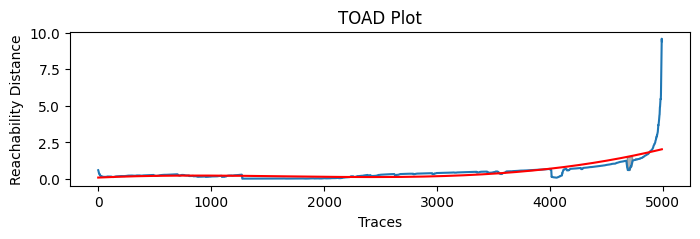

F1-Score for minpts value 20:


np.float64(0.581081081081081)

Precision-Score for minpts value 20:


np.float64(0.9148936170212766)

Recall-Score for minpts value 20:


np.float64(0.42574257425742573)

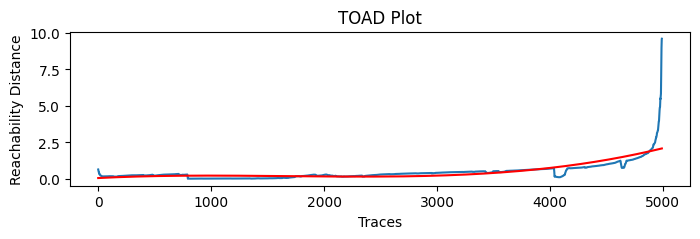

F1-Score for minpts value 25:


np.float64(0.0)

Precision-Score for minpts value 25:


c:\Users\alper\hello\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


np.float64(0.0)

Recall-Score for minpts value 25:


np.float64(0.0)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.7172003177047649

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.42551221357667796

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.4610600799474972

In [30]:
ansatz2_bpi17results = metrics('BPIC17_offer_first5000traces.jsonocel', 'BPIC17_offer_first5000traces_anomalous_app_objects.txt', 10, 1.2)

In [31]:
ansatz2_bpi17results.to_csv('results/ansatz2_bpi17results.csv', index=False)

Number of traces:  1199
Number of relations:  4699


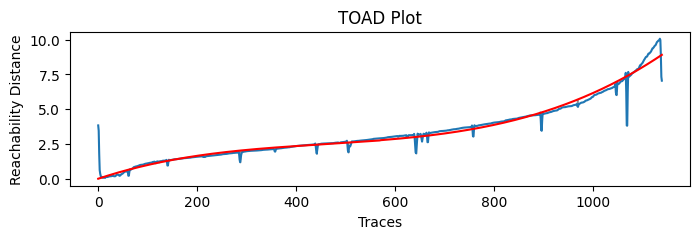

F1-Score for minpts value 2:


np.float64(0.03543307086614173)

Precision-Score for minpts value 2:


np.float64(0.6)

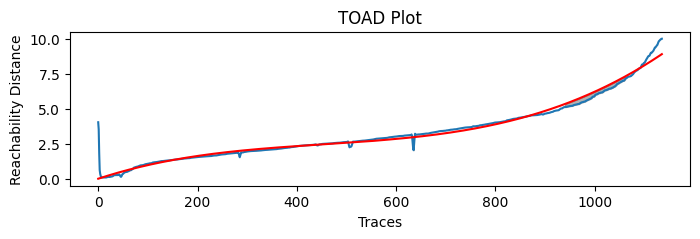

F1-Score for minpts value 4:


np.float64(0.16883116883116883)

Precision-Score for minpts value 4:


np.float64(0.42276422764227645)

C:\Users\alper\AppData\Local\Temp\ipykernel_1740\2886965209.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_1740\2886965209.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


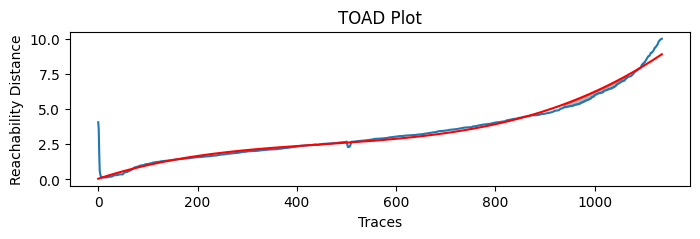

F1-Score for minpts value 5:


np.float64(0.1642512077294686)

Precision-Score for minpts value 5:


np.float64(0.3984375)

C:\Users\alper\AppData\Local\Temp\ipykernel_1740\2886965209.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_1740\2886965209.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


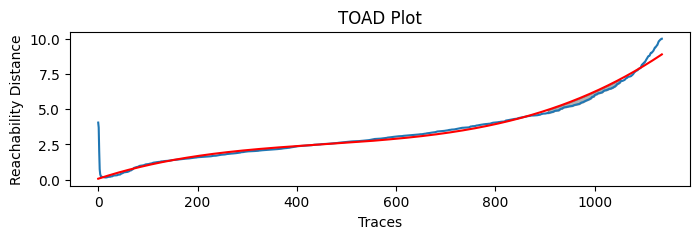

F1-Score for minpts value 10:


np.float64(0.17214397496087636)

Precision-Score for minpts value 10:


np.float64(0.3767123287671233)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


np.float64(0.4949663561820156)

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


np.float64(0.41154842068839137)

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


np.float64(0.13516485559691388)

[np.float64(0.13516485559691388),
 np.float64(0.4949663561820156),
 np.float64(0.41154842068839137)]

In [ ]:
metrics('BPIC15_Municipality1_Injected.jsonocel', 'BPI15_Municipality1_anomalous_objects.txt')

Number of traces:  1199
Number of relations:  121


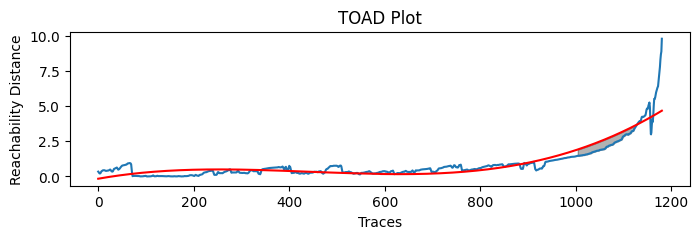

F1-Score for minpts value 5:


np.float64(0.060240963855421686)

Precision-Score for minpts value 5:


np.float64(0.042735042735042736)

Recall-Score for minpts value 5:


np.float64(0.10204081632653061)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


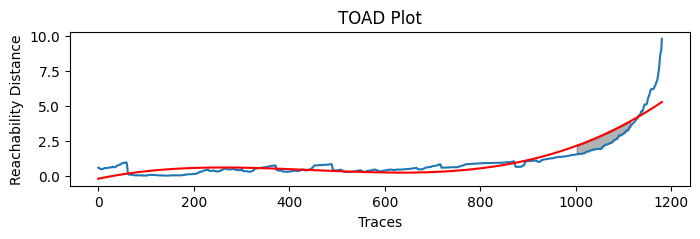

F1-Score for minpts value 10:


np.float64(0.062111801242236024)

Precision-Score for minpts value 10:


np.float64(0.044642857142857144)

Recall-Score for minpts value 10:


np.float64(0.10204081632653061)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


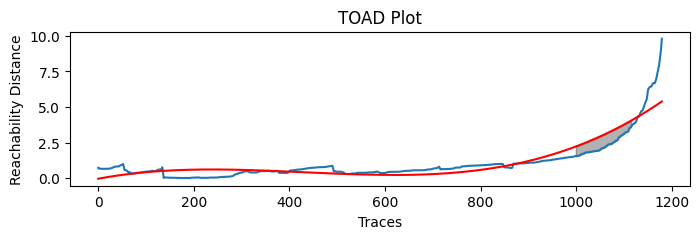

F1-Score for minpts value 15:


np.float64(0.07272727272727272)

Precision-Score for minpts value 15:


np.float64(0.05172413793103448)

Recall-Score for minpts value 15:


np.float64(0.12244897959183673)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


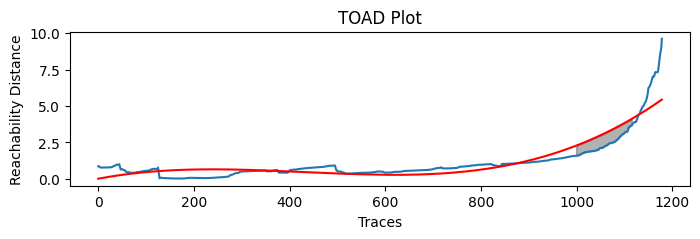

F1-Score for minpts value 20:


np.float64(0.07272727272727272)

Precision-Score for minpts value 20:


np.float64(0.05172413793103448)

Recall-Score for minpts value 20:


np.float64(0.12244897959183673)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


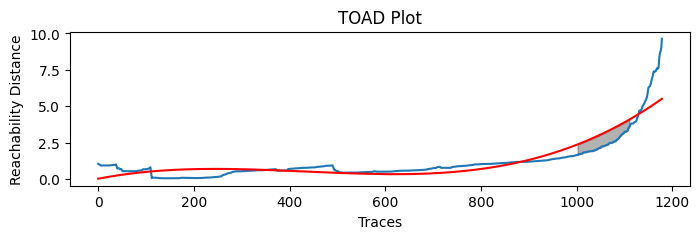

F1-Score for minpts value 25:


np.float64(0.06369426751592357)

Precision-Score for minpts value 25:


np.float64(0.046296296296296294)

Recall-Score for minpts value 25:


np.float64(0.10204081632653061)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.5036113575865129

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.041587378184624574

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.06630031561362534

In [32]:
ansatz2_bpi15_10results = metrics('BPI15_1_10h_10p_6act.jsonocel', 'BPI15_1_10h_10p_anomalous_app_objects.txt', 10, 1.2)

In [33]:
ansatz2_bpi15_10results.to_csv('results/ansatz2_bpi15_10results.csv', index=False)

Number of traces:  1199
Number of relations:  121


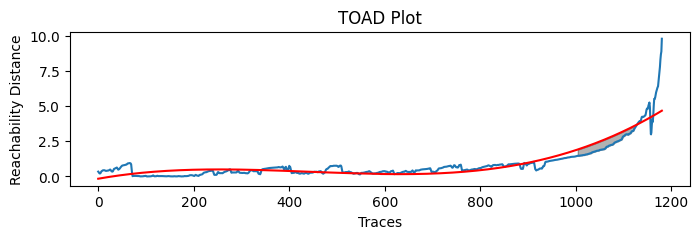

F1-Score for minpts value 5:


np.float64(0.060240963855421686)

Precision-Score for minpts value 5:


np.float64(0.042735042735042736)

Recall-Score for minpts value 5:


np.float64(0.10204081632653061)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


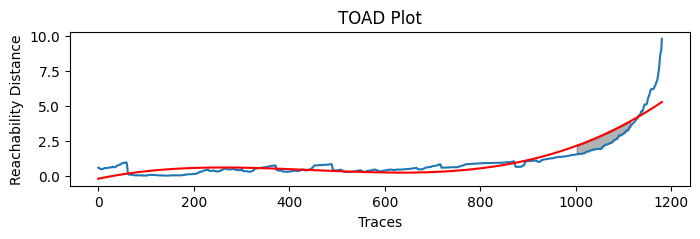

F1-Score for minpts value 10:


np.float64(0.062111801242236024)

Precision-Score for minpts value 10:


np.float64(0.044642857142857144)

Recall-Score for minpts value 10:


np.float64(0.10204081632653061)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


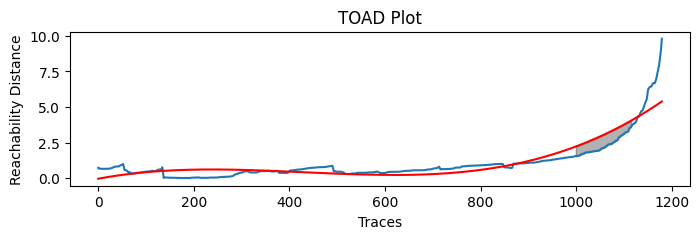

F1-Score for minpts value 15:


np.float64(0.07272727272727272)

Precision-Score for minpts value 15:


np.float64(0.05172413793103448)

Recall-Score for minpts value 15:


np.float64(0.12244897959183673)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


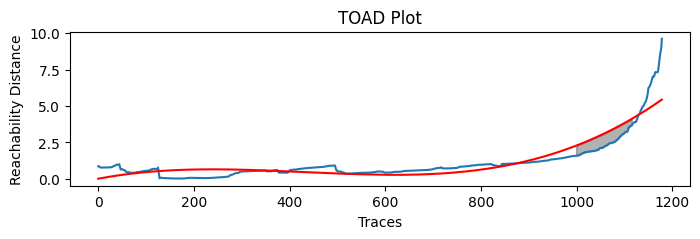

F1-Score for minpts value 20:


np.float64(0.07272727272727272)

Precision-Score for minpts value 20:


np.float64(0.05172413793103448)

Recall-Score for minpts value 20:


np.float64(0.12244897959183673)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


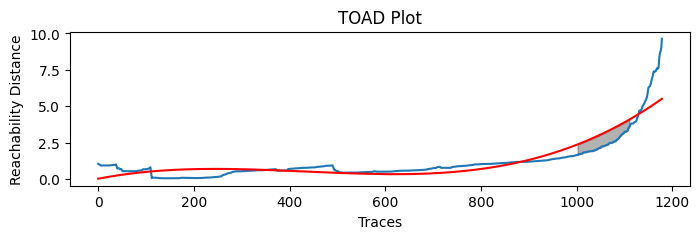

F1-Score for minpts value 25:


np.float64(0.06369426751592357)

Precision-Score for minpts value 25:


np.float64(0.046296296296296294)

Recall-Score for minpts value 25:


np.float64(0.10204081632653061)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


np.float64(0.5036113575865129)

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


np.float64(0.041587378184624574)

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


np.float64(0.06630031561362534)

[np.float64(0.06630031561362534),
 np.float64(0.5036113575865129),
 np.float64(0.041587378184624574)]

In [ ]:
metrics('BPI15_1_10h_10p_6act.jsonocel', 'BPI15_1_10h_10p_anomalous_app_objects.txt',10, 1.2)

Number of traces:  1199
Number of relations:  121


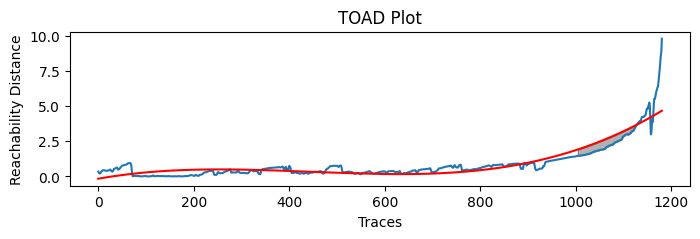

F1-Score for minpts value 5:


np.float64(0.06511627906976744)

Precision-Score for minpts value 5:


np.float64(0.05982905982905983)

Recall-Score for minpts value 5:


np.float64(0.07142857142857142)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


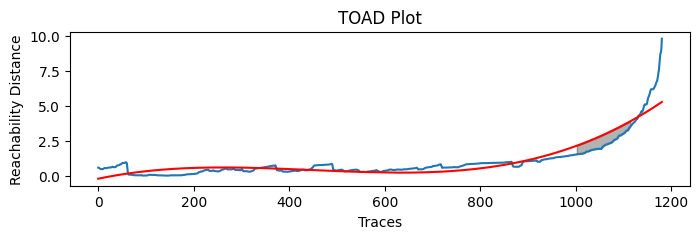

F1-Score for minpts value 10:


np.float64(0.06666666666666667)

Precision-Score for minpts value 10:


np.float64(0.0625)

Recall-Score for minpts value 10:


np.float64(0.07142857142857142)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


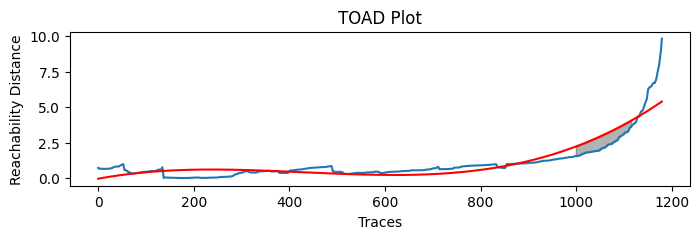

F1-Score for minpts value 15:


np.float64(0.07476635514018691)

Precision-Score for minpts value 15:


np.float64(0.06896551724137931)

Recall-Score for minpts value 15:


np.float64(0.08163265306122448)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


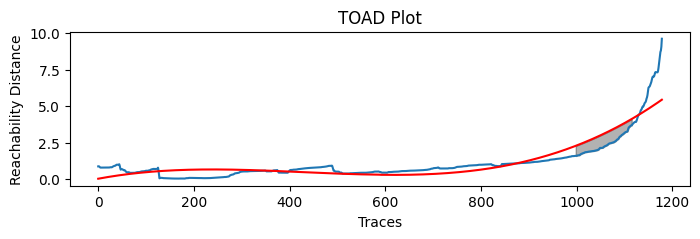

F1-Score for minpts value 20:


np.float64(0.08372093023255814)

Precision-Score for minpts value 20:


np.float64(0.07692307692307693)

Recall-Score for minpts value 20:


np.float64(0.09183673469387756)

C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_30904\2833575375.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


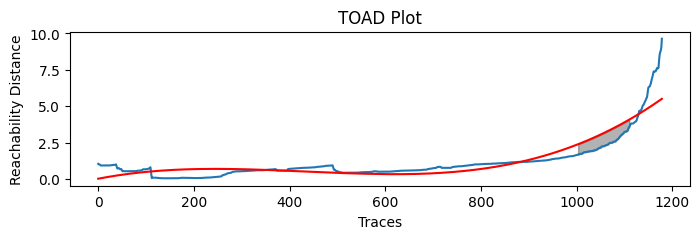

F1-Score for minpts value 25:


np.float64(0.07804878048780488)

Precision-Score for minpts value 25:


np.float64(0.07476635514018691)

Recall-Score for minpts value 25:


np.float64(0.08163265306122448)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.49209438543809897

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.0812031596492433

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45] is: 


0.07366380231939681

In [34]:
ansatz2_bpi15_20results = metrics('BPIC15_1_20h_20p_6act.jsonocel', 'BPIC15_1_20h_20p_6act_anomalous_app_objects.txt',10, 1.2)

In [35]:
ansatz2_bpi15_20results.to_csv('results/ansatz2_bpi15_20results.csv', index=False)